In [1]:

import sys
import os
sys.path.append('/Users/clancy/repos/meg')


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from numpy.linalg import norm
from dipole_class import DipoleLocalizer
from data_generator_class import DataGenerator
import mpld3

#%matplotlib notebook

In [2]:
config_file = "configs/brainNoise.yaml"

# initialize dipole with config file
dip_loc = DipoleLocalizer(config_file)  #

# create DataGenerator object using configuration passed to dip_loc
dip_gen = DataGenerator(dip_loc)   #

minBrainNoise = 1e-13
maxBrainNoise = 5e-11
numDipoles = 1000
minDepthRatio = 0.5
maxDepthRatio = 0.75 
numTimeSteps = 1001
numSeconds = 2
use_sensors = [1,4,10,9]

ret = dip_gen.simulate_brain_noise(minBrainNoise, maxBrainNoise, 
                                    numDipoles, minDepthRatio, maxDepthRatio, numTimeSteps, numCycles=numSeconds)


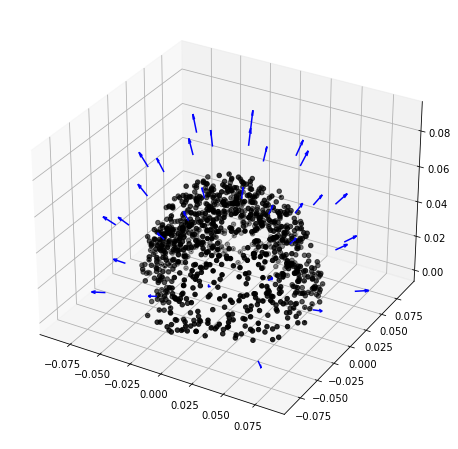

In [3]:
brainNoise = ret[0]  # rows correspond to reading on different sensors
Plist = ret[1]  # locations of 
Qlist = ret[2]
magList = np.array(ret[3])

p_true = np.array(Plist)
q_true = np.array(Qlist)
q_true = (q_true.T*magList.T).T*2e7

sensors = dip_loc.sensors
sensor_dirs = dip_loc.sensor_directions

# plot true and estimated dipole locations and moments along with sensor locations
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection='3d');
scat = ax.scatter(p_true[:,0], p_true[:,1], p_true[:,2], label='True dipole', color='k')
scat = ax.quiver(p_true[:,0], p_true[:,1], p_true[:,2], q_true[:,0], q_true[:,1], q_true[:,2], color='k')
scat = ax.quiver(sensors[:,0], sensors[:,1], sensors[:,2], sensor_dirs[:,0], sensor_dirs[:,1], sensor_dirs[:,2], length=0.01, color='b')
plt.show()


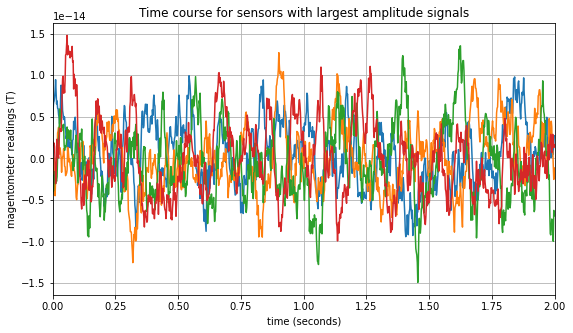

In [4]:
# take the sensors with largest magnitude over time course and look
# and their spectra
idx = np.argsort(np.linalg.norm(brainNoise, axis=1));
time_ticks = [numSeconds*i/numTimeSteps for i in range(numTimeSteps)]

fig = plt.figure(figsize=(9,5))
num_to_plot = 4
plt.plot( time_ticks,  brainNoise[ idx[0:num_to_plot], : ].T  );
plt.xlabel('time (seconds)')
plt.ylabel('magentometer readings (T)')
plt.title('Time course for sensors with largest amplitude signals')
plt.xlim([0,numSeconds])
plt.grid()


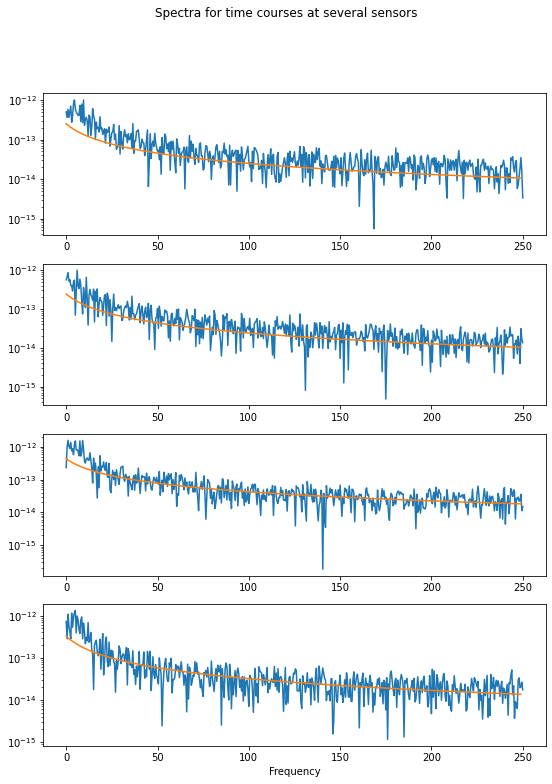

In [5]:
#courses_to_plots = brainNoise[0:num_to_plot,:]
courses_to_plots = brainNoise[use_sensors,:]


fig = plt.figure(figsize=(9,num_to_plot*3))
plt.suptitle('Spectra for time courses at several sensors')
for i, y in enumerate(courses_to_plots):
    plt.subplot(num_to_plot,1,i+1);
    fy = np.abs(np.fft.rfft(y));
    #plt.loglog(np.arange(0,len(fy))/numSeconds, fy)
    #plt.loglog([(10/numSeconds)*np.mean(fy[0:10])/(j+1) for j in range(10,10+int(0.5*numTimeSteps/numSeconds))])
    plt.semilogy(np.arange(0,len(fy))/numSeconds, fy)
    plt.semilogy([(10/numSeconds)*np.mean(fy[0:10])/(j+1) for j in range(10,10+int(0.5*numTimeSteps/numSeconds))])
plt.xlabel('Frequency')
plt.show()

Now that we have found a decent model to simulate brain noise, it's time to simulate external noise. Since there are so many possibilities for how to do this, maybe the best method is to call a function whose arguments are locations, orientation, and magnitude, then feed it into a method for `data_generator_class.py` then return a data array with contributions at the sensors from specified external noise source.

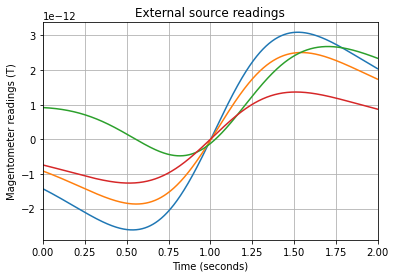

In [6]:
# start by generating source location data
# in this case, generate a source that moving vertically along z-axis (think elevator)

xs = np.zeros((numTimeSteps,1))
ys = 10*np.ones((numTimeSteps,1))
zs = np.linspace(-10, 10,numTimeSteps).reshape(numTimeSteps,1)

locs = np.hstack((xs,ys,zs))        # locations of dipole 
scas = 1e-1*np.ones(numTimeSteps)   # scales of dipoles (signed magnitudes)
oris = np.zeros((numTimeSteps,3))   # unit orientations (let above take care sign)
oris[:,2] = 1

externalNoise = dip_gen.simulate_external_noise(locs,scas, oris)



plt.plot(time_ticks, externalNoise[use_sensors,:].T);
plt.xlabel('Time (seconds)')
plt.ylabel('Magentometer readings (T)')
plt.title('External source readings')
plt.xlim([0,numSeconds])
plt.grid()
plt.show()



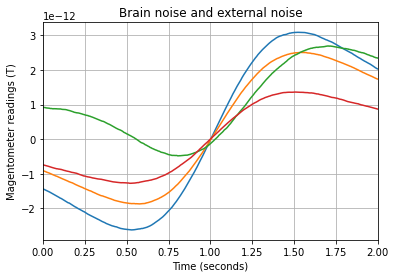

In [7]:
plt.plot([numSeconds*i/numTimeSteps for i in range(numTimeSteps)], (brainNoise.T + externalNoise.T)[:,use_sensors]);
plt.title('Brain noise and external noise')
plt.xlabel('Time (seconds)')
plt.ylabel('Magentometer readings (T)')
plt.xlim([0,numSeconds])
plt.grid()
plt.show()

In [8]:
# now we should add an actual source dipole to the volume


rInner = .07
rOuter = 0.085
p,q = dip_gen.get_random_unit_dipole(rInner, rOuter)

L = dip_gen.lead_field_obj.get_lead_field(p)

b = 2.e-8*L@q
freq = 2*np.pi*2
sig = np.sin(np.linspace(0,2*np.pi*freq,numTimeSteps))
B = np.outer(b,sig)

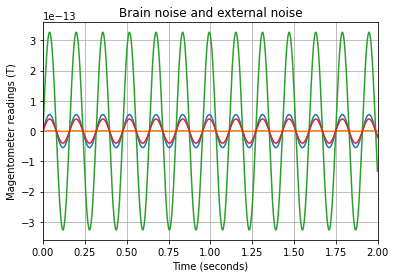

In [9]:
plt.plot(time_ticks, B[use_sensors,:].T);
plt.title('Brain noise and external noise')
plt.xlabel('Time (seconds)')
plt.ylabel('Magentometer readings (T)')
plt.xlim([0,numSeconds])
plt.grid()
plt.show()

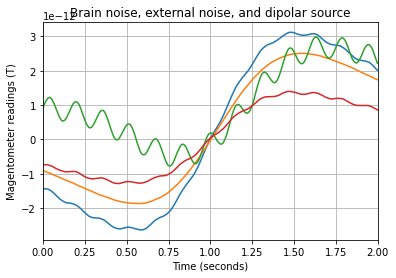

In [10]:
BB = B + externalNoise + brainNoise
plt.plot(time_ticks, BB[use_sensors,:].T);
plt.title('Brain noise, external noise, and dipolar source')
plt.xlabel('Time (seconds)')
plt.ylabel('Magentometer readings (T)')
plt.xlim([0,numSeconds])
plt.grid()
plt.show()